# General analysis CMU Movie Summary corpus
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus

**Overview**:
* 1. [Loading data and handling outliers movie metadata](#Section_1)
  * 1.1 Loading all data
  * 1.2 Loading all distinct dataframes
  * 1.3 Missing values and outliers
    * 1.3.1 Identifying missing values
    * 1.3.2 Outliers
* 2. [Exploratory data analysis movie metadata](#Section_2)
  * 2.1 Analysing genres
  * 2.2 Romantic movies runtime
  * 2.3 Romantic movies box office revenue
  * 2.4 Romantic movies countries
  * 2.5 Romantic movies languages
  * 2.6 Evolution over time
    * 2.6.1 Box office revenue over time
    * 2.6.2 Evolution of runtime
* 3. [Exploratory data analysis character metadata](#Section_3)
  * 3.1 Missing values and outliers
  * 3.2 Merging movie metadata and character metadata
  * 3.3 Gender analysis
  * 3.4 Age of actor analysis



In [229]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.tree import Tree
import xml.etree.ElementTree as ET
import itertools
import matplotlib.dates as mdates

from load_data import *
pd.options.mode.chained_assignment = None


<a id='Section_1'></a>
## 1. Loading data and handling outliers

### 1.1 Loading all data

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summary of each movie, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv). We extract all coreNLP files, then uncompress them to the XML format. Note: Extraction of CoreNLP files takes 15 minutes, while conversion takes 30 seconds.

In [230]:
download_data()

### 1.2 Loading all distinct dataframes

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

`name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

`tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [231]:
# Load plot summaries
plot_df = load_plot_df()

# Load movie metadata
movie_df = load_movie_df()

# Load character metadata
char_df = load_char_df()

# Load name clusters
names_df = load_names_df()

# Load tv tropes
cluster_df = load_cluster_df()

### 1.3 Missing values and outliers

#### 1.3.1 Identifying missing values
The analysis below shows that several features contain missing values. Most notably, 90% of the box office revenue values and 25% of the runtimes are missing. Since our research question is not focused on these features, this will not pose a big problem. On the other hand, only 2.8% of the genres is missing, which will be beneficial for identifying romantic movies. 

For the exploratory analysis, we will remove the observations with a missing value for the feature that we discuss. We note that we will miss information by discarding these values. However, since the exploratory analysis is mostly for gaining an understanding of the data, this is not a problem.

In [232]:
# Find number of missing values for each column
missing_values = movie_df.isnull().sum()
missing = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in movie_df.columns:
    missing.append([col, missing_values[col], round(missing_values[col]/len(movie_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))

,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Name,0,0.00
Release date,6902,8.44
Box office revenue,73340,89.72
Runtime,20450,25.02
Languages,13866,16.96
Countries,8154,9.98
Genres,2294,2.81


#### 1.3.2 Outliers
The data contains some outliers, we have observed the following points:

- We note that there is one movie with a release date in the year 1010 ('Hunting season'), we manually correct this to the date 2010
- There are many movies with very short runtimes (under 5 minutes). We manually verified a sample of these movies, and have found that the runtimes are correct. They mostly correspond to short movies from the early 20th century.
- There are over a hundred movies with runtimes over 5 hours. We have found that most of these data points correspond to series, where the runtime is the sum of the episode lengths.
- One movie has a runtime of over a million minutes ('Zero tolerance'). This lengths is manually corrected to 88 minutes.

In [233]:
# Isolate the year from the release date
getYear = lambda x: x[slice(0,4)] if type(x) == str else x
movie_df['Release date'] = movie_df['Release date'].apply(getYear)

# Correct release date of 1010
movie_df['Release date'][movie_df['Wikipedia ID']==29666067] = '2010'

# Correct runtime of over a million minutes
movie_df['Runtime'][movie_df['Wikipedia ID']==10815585] = 88

def sanitycheck(df):
    # Remove movies with nan for release date or nan for runtime
    df = df[df['Release date'].notna()]
    df = df[df['Runtime'].notna()]
    # Make a boolean that is true if there is a release date before 1900
    before1900 = any(df['Release date'].apply(lambda x: int(x) < 1880))
    # Make a boolean that is true if there is a runtime over 20000 minutes
    # Note that we allow long runtimes, as we keep series in the dataset
    over10hours = any(df['Runtime'].apply(lambda x: int(x) > 20000))
    if before1900 or over10hours:
        print('Sanity check failed')
    else:
        print('Sanity check passed')
sanitycheck(movie_df)

Sanity check passed


<a id='Section 2'></a>
## 2. Exploratory Data Analysis movie metadata

### 2.1 Analysing genres

Let us first find the total number of unique genres and plot the 10 most occuring genres. The plot shows that drama occurs much more than the other genres. The subsequent genres have a similar appearance frequency. 

Number of unique genres:  363


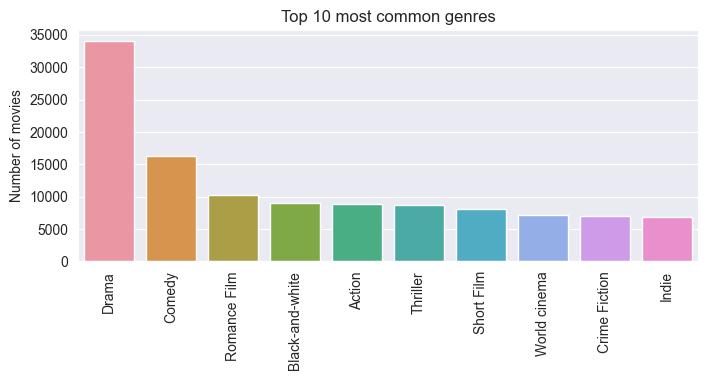

In [234]:
#Remove missing genres
genres = movie_df['Genres'].apply(lambda x: x if type(x) == list else [])

# Find number of unique genres
unique_genres = set(itertools.chain.from_iterable(genres))
print('Number of unique genres: ', len(unique_genres))

# Find top 10 most common genres
genre_counts = {}
for genre in unique_genres:
    genre_counts[genre] = sum(genres.apply(lambda x: genre in x))
genre_counts = {k: v for k, v in sorted(
    genre_counts.items(), key=lambda item: item[1], reverse=True)}
genre_counts = {k: genre_counts[k] for k in list(genre_counts)[:10]}


# Plot histogram with top 10 most common genres using seaborn
plt.figure(figsize=(8, 3))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=90)
plt.title('Top 10 most common genres')
sns.set_palette("flare")
sns.set_style('darkgrid')
plt.ylabel('Number of movies')
plt.show()



Let us now focus on the romantic genres and discover the different flavors. The plot below shows that romantic films, romantic comedies and romantic dramas are most present. There are fewer romantic fantasy's, and just 1 romantic thriller - [Bloody isshq](https://en.wikipedia.org/wiki/Bloody_Isshq), which tells the tale of Natasha, a "brash, deviant man-eater". 

,Number of movies
Genre,
Romantic comedies,2680
Romantic films,10234
Romantic drama,3372
Romantic fantasy,72
Romantic thriller,1


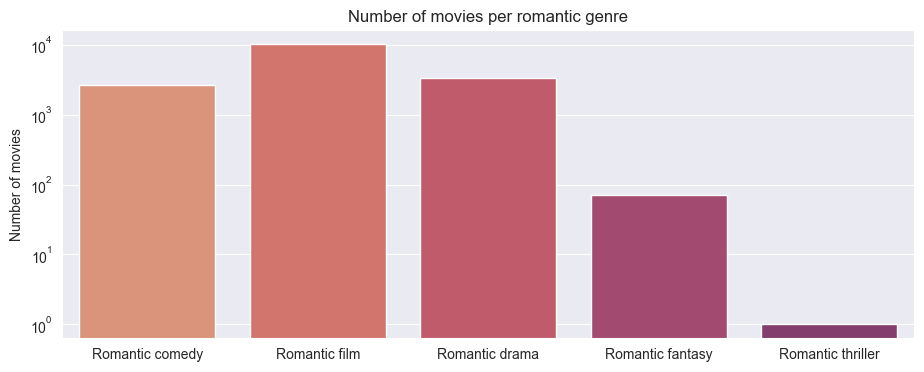

In [235]:
romance_genres = ['Romantic comedy', 'Romance Film',
                  'Romantic drama', 'Romantic fantasy', 'Romantic thriller']


def is_romantic(i): return lambda x: any(
    y in romance_genres[i] for y in x) if type(x) == list else False


def is_not_romantic(i): return lambda x: not any(
    y in romance_genres[i] for y in x) if type(x) == list else False


romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies = movie_df[movie_df['Genres'].apply(
    is_not_romantic(slice(0, 5)))]

#Organize by category
romantic_comedy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(0))]
romantic_film = romance_movies.loc[movie_df['Genres'].apply(is_romantic(1))]
romantic_drama = romance_movies.loc[movie_df['Genres'].apply(is_romantic(2))]
romantic_fantasy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(3))]
romantic_thriller = romance_movies.loc[movie_df['Genres'].apply(
    is_romantic(4))]

num_movies = [['Romantic comedies', romantic_comedy.shape[0]], ['Romantic films', romantic_film.shape[0]], ['Romantic drama', romantic_drama.shape[0]], ['Romantic fantasy', romantic_fantasy.shape[0]], ['Romantic thriller', romantic_thriller.shape[0]]]
table = [['Genre', 'Number of movies']] + num_movies
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Genre'))

# Using seaborn, make a barplot with the number of movies per romantic genre with log axes
plt.figure(figsize=(11, 4))
sns.barplot(x=['Romantic comedy', 'Romantic film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller'], y=[
            romantic_comedy.shape[0], romantic_film.shape[0], romantic_drama.shape[0], romantic_fantasy.shape[0], romantic_thriller.shape[0]])
plt.yscale('log')
plt.title('Number of movies per romantic genre')
plt.ylabel('Number of movies')
# Add color palette green
sns.set_palette("flare")
# Add dark background
sns.set_style('darkgrid')
plt.show()


**Frequent itemset mining introduction**

Up to now, we have not considered combinations of genres. Let us now investigate which genres often cooccur together. To do so, we use frequent itemset mining. Let us first introduce several concepts, before diving into the analysis. We define the support of a genre as follows:

$\text{Support(genre X)}=\frac{\text{Number of movies with genre X}}{\text{Total number of movies}}$

The support thus tells us how prevalent a genre is in the dataset. We can also calculate the support for multiple genres together, such as "comedy" and "action", we then divide the number of movies with **both** action and comedy as a genre by the total number of movies. 

To analyze the cooccurence of genres, we use the lift measure:

$\text{lift(genre X and genre Y)} = \frac{\text{Support(genre X and genre Y)}}{\text{Support(genre X)} \cdot \text{Support(genre Y)}}$

Intuitively, if the lift is higher than 1, it means that 2 genres cooccur more frequently than one would expect based on their individual supports. This gives a natural threshold, if the lift is higher than 1, we have found an association between 2 genres.

**Analysis of results**

The heatmap below shows several association rules. The most prominent association is between action and action/adventure, which is not surprising. More interestingly, we see that drama is associated with many other genres. This explains the high presence of the drama genre that we saw before, as it is thus paired with many other genres. 

When we focus on the romantic movies, we see that romance film is associated with comedy and drama. This is in line with what we saw before, as romantic comedies and romantic dramas are the most present romantic genres in the data.

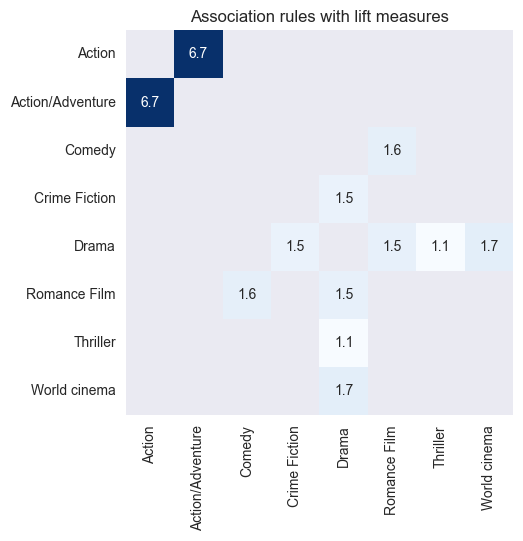

In [236]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Encode using one-hot encoding
tr = TransactionEncoder()
tr_arr = tr.fit(genres).transform(genres)
one_hot = pd.DataFrame(tr_arr, columns=tr.columns_)

# Find frequent itemsets
freq_itemsets = apriori(one_hot, min_support=0.04, use_colnames=True)

# Find association rules
associations = association_rules(freq_itemsets, metric="lift", min_threshold=1)

# Rank association rules by confidence
associations = associations.sort_values(by='lift', ascending=False)
associations['antecedents'] = associations['antecedents'].apply(
    lambda x: list(x)[0])
associations['consequents'] = associations['consequents'].apply(
    lambda x: list(x)[0])
# Plot heatmap of association rules with annotations and without colorbar, no xlabel and ylabel
plt.figure(figsize=(5, 5))
sns.heatmap(associations.pivot(index='antecedents', columns='consequents',
            values='lift'), annot=True, cbar=False, cmap='Blues')
plt.title('Association rules with lift measures')
#remove xlabel and ylabel
plt.xlabel('')
plt.ylabel('')
plt.show()


### 2.2. Romantic movies runtime

Let us then analyze the runtime of romantic and non-romantic movies. We note three findings:

- Romantic comedies seem to have a lower variance in their runtime. This indicates that most romantic comedies have a runtime of approximately 100 minutes, with a relatively low spread. Intuitively, one can think of all romantic christmas comedies popping up on netflix in december, which are usually about this length.
- Non-romantic movies have a slightly lower runtime on average. There is a second peak in the density around 0-25 minutes. This corresponds to short movies, which were most present in the early 20th century.
- Among the longer movies, romantic dramas are most present. This genre thus has relatively many long movies.

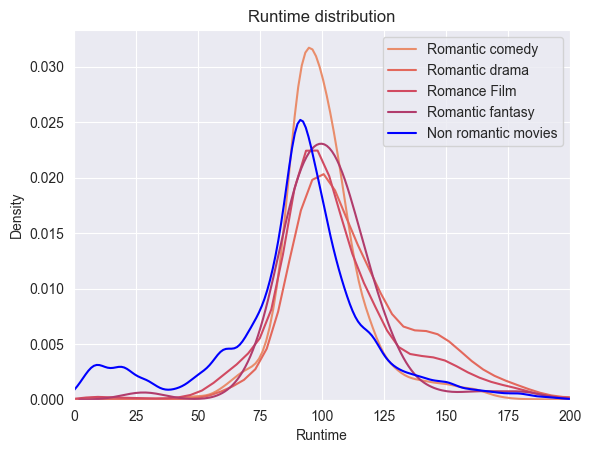

In [237]:
ax = sns.kdeplot(romantic_comedy['Runtime'])
ax = sns.kdeplot(romantic_drama['Runtime'])
ax = sns.kdeplot(romantic_film['Runtime'])
ax = sns.kdeplot(romantic_fantasy['Runtime'])

#remove runtime over 200 for non romantic movies
non_romance_movies = non_romance_movies[non_romance_movies['Runtime'] < 200]

ax = sns.kdeplot(non_romance_movies['Runtime'], color='blue')
ax.set_xlim(0, 200)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film',
          'Romantic fantasy', 'Non romantic movies'])
plt.title('Runtime distribution')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


### 2.3. Romantic movies box office revenue

Next, we discuss the box office revenue of romantic and non-romantic movies. Specifically, there are two findings:
- Romantic fantasy movies generate a higher revenue, on average. However, we note that there are only 72 romantic fantasy's in the dataset, which is a small sample. In this sample, there are several blockbusters, such as twilight (which is the prime example of the absence of a direct relation between revenue and quality).
- Romantic comedies yield a slightly higher revenue than romantic dramas, romance films and non-romantic movies.

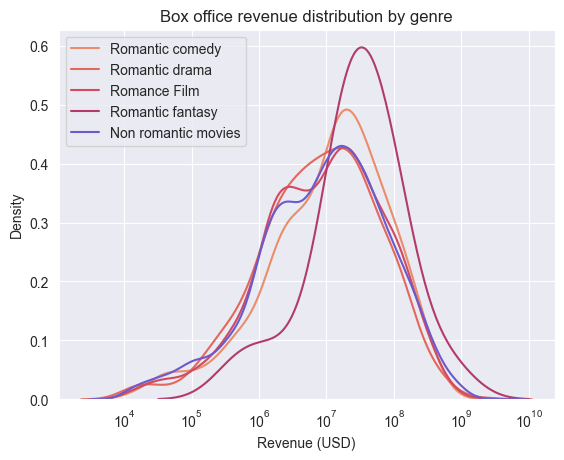

In [238]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True)
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True)
ax = sns.kdeplot(non_romance_movies['Box office revenue'], log_scale=True, color='slateblue')
colors = [line.get_color() for line in ax.get_lines()]
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])
plt.title('Box office revenue distribution by genre')
plt.xlabel('Revenue (USD)')
plt.ylabel('Density')
sns.set_style('darkgrid')
sns.set_palette('flare')
plt.show()


### 2.4. Romantic movies countries

Let us now consider the country of production of movies. The histogram below shows that generally a movie is made in one country. Romantic fantasies are more often produced in multiple countries, however, also for this genre 75% is produced in one country.

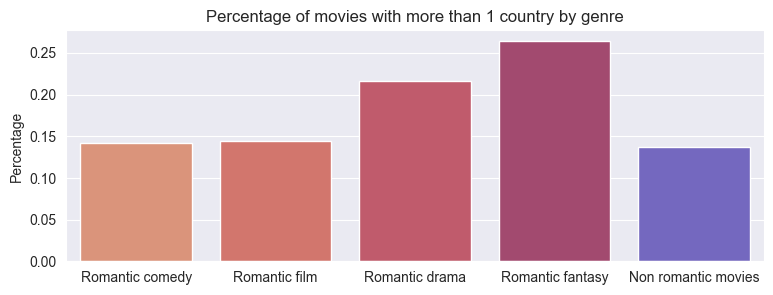

In [239]:
# Store number of countries for each movie
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)
non_romance_movies['number_countries'] = non_romance_movies['Countries'].apply(get_countries)

#Plot percentage of movies with more than 1 country, for romantic genres and non-romantic movies
plt.figure(figsize=(9, 3))
sns.barplot(x=['Romantic comedy', 'Romantic film', 'Romantic drama', 'Romantic fantasy', 'Non romantic movies'], y=[
                romantic_comedy[romantic_comedy['number_countries'] > 1].shape[0]/romantic_comedy.shape[0], romantic_film[romantic_film['number_countries'] > 1].shape[0]/romantic_film.shape[0], romantic_drama[romantic_drama['number_countries'] > 1].shape[0]/romantic_drama.shape[0], romantic_fantasy[romantic_fantasy['number_countries'] > 1].shape[0]/romantic_fantasy.shape[0], non_romance_movies[non_romance_movies['number_countries'] > 1].shape[0]/non_romance_movies.shape[0]], 
                palette=colors)
plt.title('Percentage of movies with more than 1 country by genre')
plt.ylabel('Percentage')
sns.set_style('darkgrid')
plt.show()

Let us then dive into which countries are most present. For each genre, the USA is by far the most frequent country of production. We note a few differences in the production country between genres:
- India is common for romantic dramas and romance movies, but is less prevalent for romantic comedies. For romantic fantasy's, India is not even in the top 5.
- While Italy is in the top 5 for non-romantic movies and romantic dramas, it is not in the top 5 for other romance genres. 
- Germany is in the top 5 for romantic comedy's and romance films, but not for non-romantic films. 

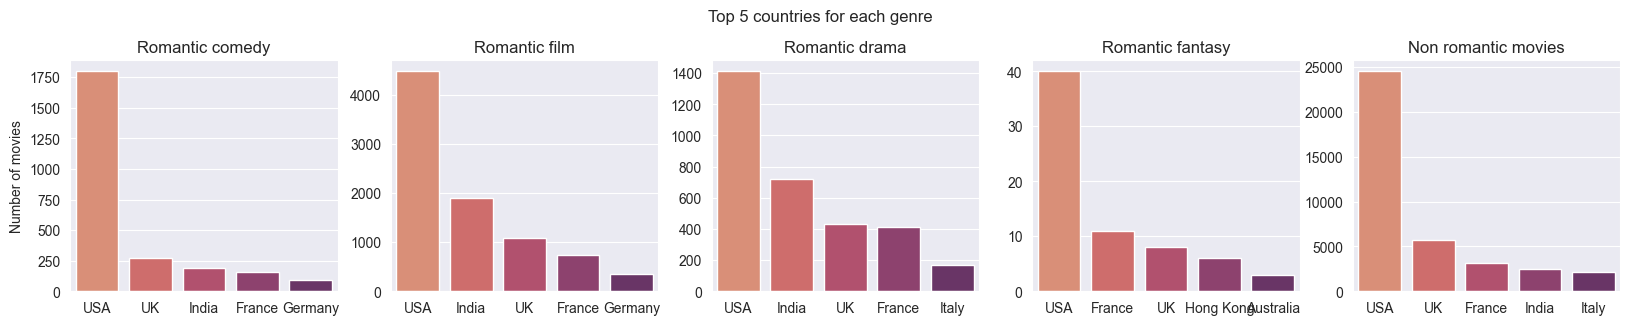

In [240]:
#Find the five most frequent countries for each romantic genre, and plot them for each genre
romantic_comedy_countries = romantic_comedy['Countries'].explode().value_counts().head(5)
romantic_film_countries = romantic_film['Countries'].explode().value_counts().head(5)
romantic_drama_countries = romantic_drama['Countries'].explode().value_counts().head(5)
romantic_fantasy_countries = romantic_fantasy['Countries'].explode().value_counts().head(5)
non_romance_countries = non_romance_movies['Countries'].explode().value_counts().head(5)

# Make a multi figure plot with 5 subplots, each giving top 5 countries for each romantic genre and for non-romantic movies using seaborn
fig, axs = plt.subplots(1, 5, figsize=(20, 3))
sns.barplot(x=romantic_comedy_countries.index, y=romantic_comedy_countries.values, ax=axs[0], palette='flare')
sns.barplot(x=romantic_film_countries.index, y=romantic_film_countries.values, ax=axs[1], palette='flare')
sns.barplot(x=romantic_drama_countries.index, y=romantic_drama_countries.values, ax=axs[2], palette='flare')
sns.barplot(x=romantic_fantasy_countries.index, y=romantic_fantasy_countries.values, ax=axs[3], palette='flare')
sns.barplot(x=non_romance_countries.index, y=non_romance_countries.values, ax=axs[4], palette='flare')
axs[0].set_title('Romantic comedy')
axs[1].set_title('Romantic film')
axs[2].set_title('Romantic drama')
axs[3].set_title('Romantic fantasy')
axs[4].set_title('Non romantic movies')
axs[0].set_ylabel('Number of movies')
fig.suptitle('Top 5 countries for each genre', y=1.05)
sns.set_style('darkgrid')
for ax in axs.flat:
    ax.set_xticklabels([label.get_text().replace('United States of America', 'USA').replace('United Kingdom', 'UK') for label in ax.get_xticklabels()])
plt.show()

### 2.5. Movie languages

Let us then find the most common languages spoken in romantic movies and non-romantic movies. We see that in romantic movies, Hindi and Tamil are in the top 5 languages, whereas this is not the case for non-romantic movies. This is in line with the large role of india in the production of romance films and romantic dramas, which we saw in the analysis in 3.4. Furthermore, we see that japanese and italian are in the top 5 for non-romantic movies. However, these languages are absent for romantic movies.

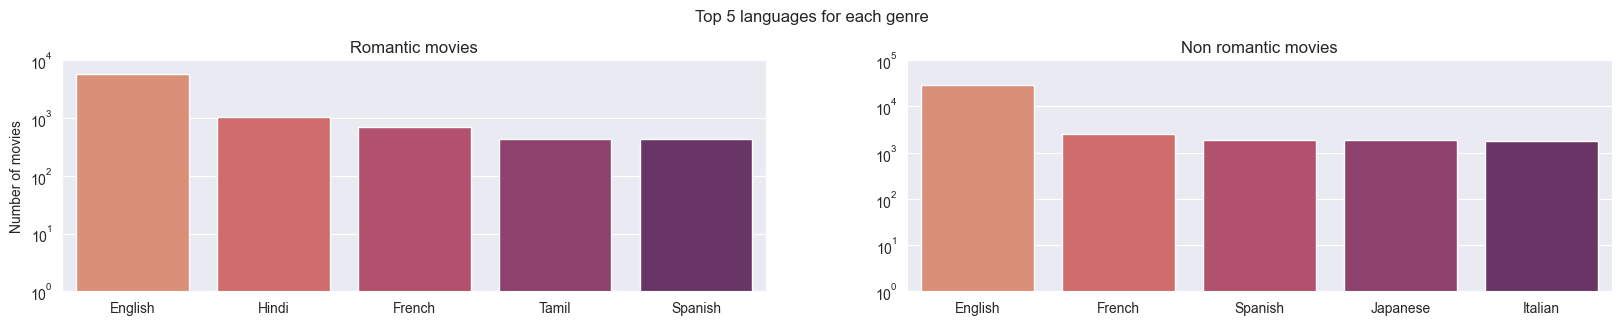

In [241]:
#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)

#Plot 5 most common languages in non romantic movies
non_romance_movies_lang = non_romance_movies[non_romance_movies['Languages'].notnull()]
languages_non_romance = non_romance_movies_lang.Languages.sum()
values_non_romance, counts_non_romance = np.unique(languages_non_romance, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(20, 3))
sns.barplot(x=values[counts.argsort()[-5:][::-1]], y=counts[counts.argsort()[-5:][::-1]], ax=axs[0], palette='flare')
sns.barplot(x=values_non_romance[counts_non_romance.argsort()[-5:][::-1]], y=counts_non_romance[counts_non_romance.argsort()[-5:][::-1]], ax=axs[1], palette='flare')
axs[0].set_title('Romantic movies')
axs[1].set_title('Non romantic movies')
axs[0].set_ylabel('Number of movies')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].set_yticks([1, 10, 100, 1000, 10000])
axs[1].set_yticks([1, 10, 100, 1000, 10000, 100000])
fig.suptitle('Top 5 languages for each genre', y=1.05)
sns.set_style('darkgrid')
plt.show()



### 2.6. Evolution over time

As a last part of the exploratory analysis of the movie metadata, we investigate the evolution of the box office revenue and the runtime over the years. 

#### 2.6.1 Box office revenue over time

Generally, we see that for both romantic and non-romantic movies the box office revenue has increased over time. The large spikes for the romantic movies correspond to outliers. Two of these outliers are "Snow white and the seven dwarfs (1937)" and "The sound of music (1965)".

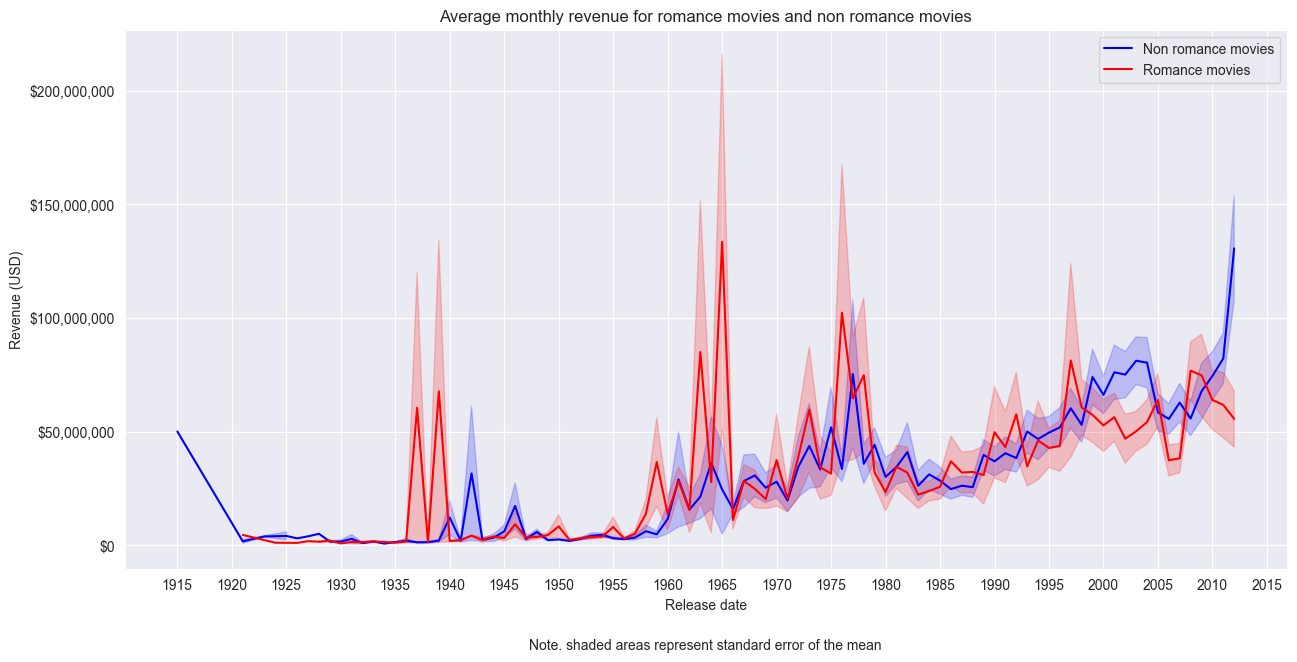

In [242]:
import matplotlib
year_box_office = non_romance_movies[[
    'Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[[
    'Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(
    year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(
    year_box_office_romance['Release date'])

# Get yearly box office revenue for romantic and non-romantic movies
year_box_office = non_romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(year_box_office_romance['Release date'])

total_mean = year_box_office.groupby('Release date').mean().iloc[1:]
romance_mean = year_box_office_romance.groupby('Release date').mean().iloc[1:]
#Compute standard error of the mean for non-romantic movies and romantic movies
total_sem = year_box_office.groupby('Release date').sem().iloc[1:]
romance_sem = year_box_office_romance.groupby('Release date').sem().iloc[1:]

# Plot average monthly revenue for romance movies and non romance movies using seaborn
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=total_mean, x=total_mean.index, y='Box office revenue', color='blue', label='Non romance movies', ax=ax)
sns.lineplot(data=romance_mean, x=romance_mean.index, y='Box office revenue', color='red', label='Romance movies', ax=ax)
ax.fill_between(total_mean.index, total_mean['Box office revenue'] - total_sem['Box office revenue'], total_mean['Box office revenue'] + total_sem['Box office revenue'], color='blue', alpha=0.2)
ax.fill_between(romance_mean.index, romance_mean['Box office revenue'] - romance_sem['Box office revenue'], romance_mean['Box office revenue'] + romance_sem['Box office revenue'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_xlabel('Release date')
ax.set_ylabel('Revenue (USD)')
ax.set_title('Average monthly revenue for romance movies and non romance movies')
ax.legend()
ax.annotate('Note. shaded areas represent standard error of the mean', xy=(0.5, 0), xytext=(
    0, -50), xycoords='axes fraction', textcoords='offset points', size=10, ha='center', va='top')
plt.show()



### 2.6.2. Evolution of runtime

Last, we consider the runtime of romantic movies and non-romantic movies over time. The plot below mostly confirms the findings from before. We see that in the early 20th century, the average runtime sharply increases. This corresponds to the transition from short movies to longer movies. This increase slowly stagnates and the curve flattens. Overall, we see that romantic movies last longer on average. 

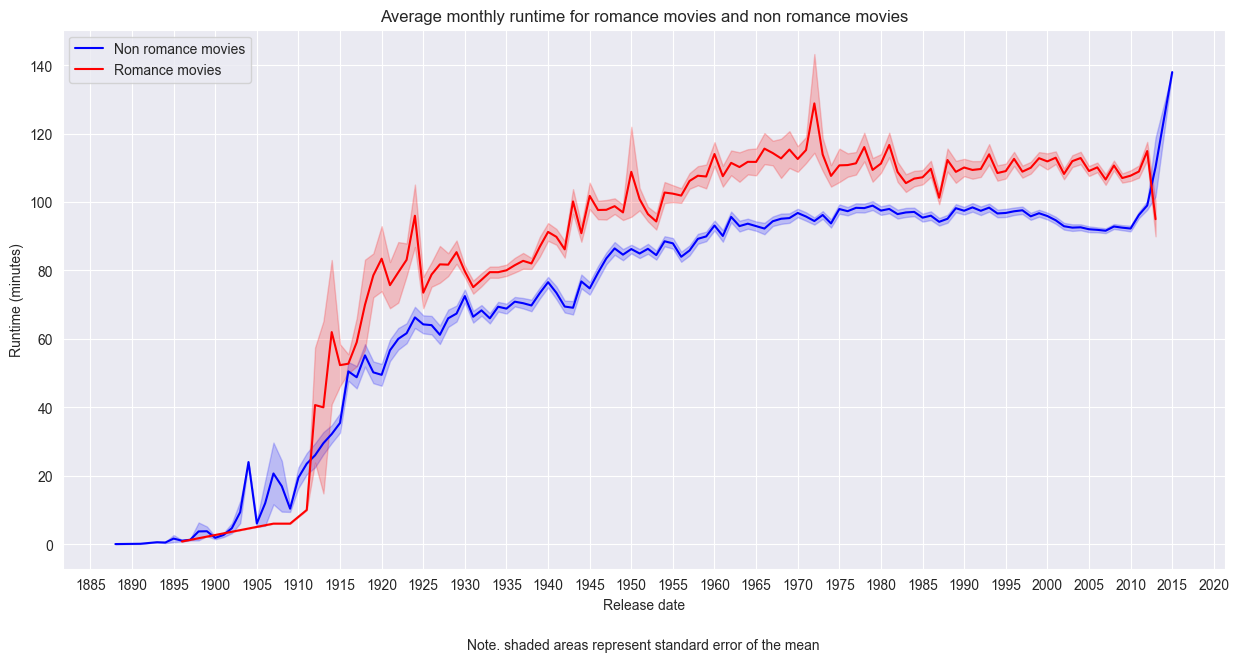

In [243]:
import matplotlib

# Get yearly runtime for romantic and non-romantic movies
year_runtime = non_romance_movies[['Release date', 'Runtime']].dropna()
year_runtime_romance = romance_movies[['Release date', 'Runtime']].dropna()
year_runtime['Runtime'] = year_runtime['Runtime'].astype(float)
year_runtime_romance['Runtime'] = year_runtime_romance['Runtime'].astype(float)

total_runtime_mean = year_runtime.groupby('Release date').mean()
romance_runtime_mean = year_runtime_romance.groupby('Release date').mean()
total_runtime_sem = year_runtime.groupby('Release date').sem().replace(np.nan, 0)
romance_runtime_sem = year_runtime_romance.groupby('Release date').sem().replace(np.nan, 0)

# Convert release date of mean and std to datetime
total_runtime_mean.index = pd.to_datetime(total_runtime_mean.index)
romance_runtime_mean.index = pd.to_datetime(romance_runtime_mean.index)
total_runtime_sem.index = pd.to_datetime(total_runtime_sem.index)
romance_runtime_sem.index = pd.to_datetime(romance_runtime_sem.index)


# Plot average monthly runtime for romance movies and non romance movies using seaborn
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=total_runtime_mean, x=total_runtime_mean.index, y='Runtime', color='blue', label='Non romance movies', ax=ax)
sns.lineplot(data=romance_runtime_mean, x=romance_runtime_mean.index, y='Runtime', color='red', label='Romance movies', ax=ax)
ax.fill_between(total_runtime_mean.index, total_runtime_mean['Runtime'] - total_runtime_sem['Runtime'], total_runtime_mean['Runtime'] + total_runtime_sem['Runtime'], color='blue', alpha=0.2)
ax.fill_between(romance_runtime_mean.index, romance_runtime_mean['Runtime'] - romance_runtime_sem['Runtime'], romance_runtime_mean['Runtime'] + romance_runtime_sem['Runtime'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Release date')
ax.set_ylabel('Runtime (minutes)')
ax.set_title('Average monthly runtime for romance movies and non romance movies')
ax.legend()
#Add footnote stating that the shaded areas represent standard error of the mean, position footnote underneath graph, small lettertype
ax.annotate('Note. shaded areas represent standard error of the mean', xy=(0.5, 0), xytext=(
    0, -50), xycoords='axes fraction', textcoords='offset points', size=10, ha='center', va='top')
plt.show()


<a id='Section_3'></a>
## 3. Exploratory analysis character metadata
As a last part of the general analysis, we consider the character metadata. 

### 3.1 Missing values and outliers



In [244]:
# Find number of missing values for each column
missing_values = movie_df.isnull().sum()
missing = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in movie_df.columns:
    missing.append([col, missing_values[col], round(missing_values[col]/len(movie_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))

,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Name,0,0.00
Release date,6902,8.44
Box office revenue,73340,89.72
Runtime,20450,25.02
Languages,13866,16.96
Countries,8154,9.98
Genres,2294,2.81


In [245]:
# Find number of missing values for each column
missing_values = char_df.isnull().sum()
missing_char = []

#Print name of column, followed by number of missing values with percentage of missing values in brackets
for col in char_df.columns:
    missing_char.append([col, missing_values[col], round(missing_values[col]/len(char_df)*100, 2)])

table = [['Category', 'Number of missing values', 'Proportion of missing values (%)']] + missing_char
display(pd.DataFrame(table[1:], columns=table[0]).set_index('Category'))




,Number of missing values,Proportion of missing values (%)
Category,,
Wikipedia ID,0,0.00
Freebase ID,0,0.00
Release date,9995,2.22
Character name,257875,57.22
Date of birth,106145,23.55
Gender,45609,10.12
Height,295845,65.65
Ethnicity,344611,76.47
Actor name,1228,0.27


In [246]:
# Divide height by 100 if the height is larger than 2.4 meters
char_df.loc[char_df['Height'] > 2.4, 'Height'] = char_df['Height']/100

# Remove rows with actors with an age over 100 and print number of rows that were removed
print('Number of rows removed for ages over 100 years: ', len(char_df.loc[char_df['Actor age at release'] > 100]))
char_df = char_df[char_df['Actor age at release'] < 100]

# Remove rows with actors with an age under 0 and print number of rows that were removed
print('Number of rows removed for ages under 0 years: ', len(char_df.loc[char_df['Actor age at release'] < 0]))
char_df = char_df[char_df['Actor age at release'] > 0]

# Remove rows with actors with a height under 1 meter and print number of rows that were removed
print('Number of rows removed for heights under 1 meters: ', len(char_df.loc[char_df['Height'] < 1.2]))
char_df = char_df[char_df['Height'] > 1]

def sanitycheck(df):
    # Check if there are any values above 2.5 meters or below 1 meter
    if (df['Height'].max() > 2.5) or (df['Height'].min() < 1):
        print('Sanity check failed: Height')
    # Check if there are any values above 100 years or below 0 years
    if (df['Actor age at release'].max() > 100) or (df['Actor age at release'].min() < 0):
        print('Sanity check failed: Age')
    else:
        print('Sanity check passed')

sanitycheck(char_df)

Number of rows removed for ages over 100 years:  2
Number of rows removed for ages under 0 years:  381
Number of rows removed for heights under 1 meters:  191
Sanity check failed: Height
Sanity check passed


### 3.2 Merging movie metadata and character metadata

We now merge the character metadata and the movie metadata. We merge on both the wikipedia ID and freebase ID, the results below show us that no data is lost from the character metadata. We do see that the release date of the character metadata and movie metadata often do not match. 

In [247]:
# Merge movie metadata and character metadata by wikipedia ID, freebase ID and release date
movie_char_df = pd.merge(movie_df, char_df, how='inner', left_on=['Wikipedia ID', 'Freebase ID'], right_on=['Wikipedia ID', 'Freebase ID'])

# print number of rows that were lost in the merge
print('Number of rows in merged movie and character dataframe: ', len(movie_char_df))
print('Number of rows in movie dataframe: ', len(movie_df))
print('Number of rows in character dataframe: ', len(char_df))

# print number of rows where the two release dates do not match
print('Number of rows where release dates do not match: ', len(movie_char_df.loc[movie_char_df['Release date_x'] != movie_char_df['Release date_y']]))

# Filter the romantic and non-romantic movies from the merged dataframe
romance_movies_merged = movie_char_df[movie_char_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies_merged = movie_char_df[movie_char_df['Genres'].apply(
    is_not_romantic(slice(0, 5)))]


Number of rows in merged movie and character dataframe:  139607
Number of rows in movie dataframe:  81741
Number of rows in character dataframe:  139607
Number of rows where release dates do not match:  96887


### 3.3 Gender analysis

We now investigate the presence of males and females in both non-romantic and romantic movies.


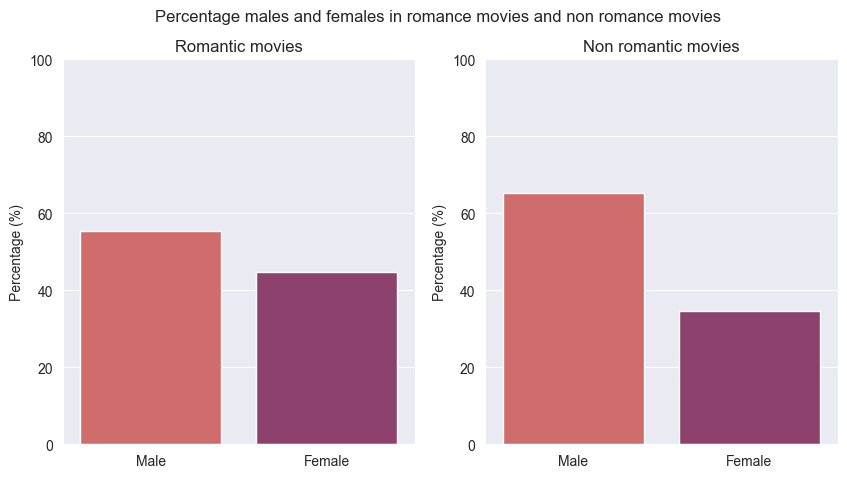

In [248]:
# Calculate percentages of gender categories in romantic and non-romantic movies
counts_romance = romance_movies_merged['Gender'].value_counts()
counts_non_romance = non_romance_movies_merged['Gender'].value_counts()
percentage_male_romance = round(counts_romance['M'] * 100/counts_romance.values.sum(), 2)
percentage_female_romance = 100 - percentage_male_romance
percentage_male_non_romance = round(counts_non_romance['M'] * 100/counts_non_romance.values.sum(), 2)
percentage_female_non_romance = 100 - percentage_male_non_romance

indices = ['Male', 'Female', 'Male', 'Female']
values = [percentage_male_non_romance, percentage_female_non_romance, percentage_male_romance, percentage_female_romance]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x=indices[0:2], y=values[0:2], ax=axs[1], palette='flare')
sns.barplot(x=indices[2:5], y=values[2:5], ax=axs[0], palette='flare')
fig.suptitle('Percentage males and females in romance movies and non romance movies')
axs[0].set_title('Romantic movies')
axs[1].set_title('Non romantic movies')
axs[0].set_ylabel('Percentage (%)')
axs[0].set_ylim(0, 100)
axs[1].set_ylabel('Percentage (%)')
axs[1].set_ylim(0, 100)
plt.show()

### 3.4 Age of actor analysis

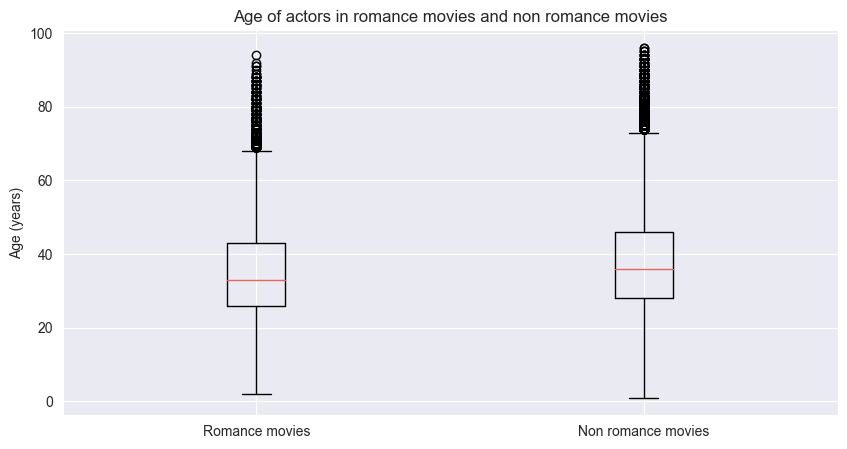

In [249]:
# Make 2 boxplots for the age of actors in romantic and non-romantic movies
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot([romance_movies_merged['Actor age at release'], non_romance_movies_merged['Actor age at release']], labels=[
              'Romance movies', 'Non romance movies'])
ax.set_title('Age of actors in romance movies and non romance movies')
ax.set_ylabel('Age (years)')
plt.show()
